# Detecting Covariate Shift in Datasets

Regression models predict a response based on predictor variables. The model parameters are etimated from the data. When the underlying data distribution associated with the predictors changes, the model and its associated parameters that were determined based on a previous batch of data, may not be optimal for the data that we are now seeing. This is known as **covariate shift**. Ok, so all that is well and good, but how do we detect that the underlying dataset distribution has changed? We can employ a simple technique to do that and we will illustrate that in this notebook.

The problem context is as follows. We have two batches of data. One is the version used to build the current model in production and the other is the batch of data that we have received since the model has been deployed. The question is **is the current batch of data different in a distributional sense from the one used to build the current model?** We will use machine learning to solve this problem. We will tag the data from the batch used to build the current production model as **0** and the batch of data that we have received since then as **1**. We will develop a model to discriminate these two labels. If the model we develop can discriminate very well between data from these two batches, then **covariate shift** has occured and we need to revisit modeling. If the model cannot discriminate well between these two batches, for example, the classifier we develop produces an accuracy of about **0.5** then this classifier is not very discriminatory. It only performs as well as tossing a fair coin. If we observe such a result, then we conclude that sufficient dataset shift has not occured and our current model will serve us well.

We illustrate this idea with the data from the **california housing** dataset (available in the UCI machine learning repository). The machine learning task associated with the dataset is to predict the **median house value** given a set of predictors. The rest of the notebook illustrates the idea discussed above. 

## Read the data

In [1]:
import pandas as pd
fp = "cal_housing.csv"
df = pd.read_csv(fp)

In [2]:
req_cols = df.columns.tolist()
req_cols.remove("medianHouseValue")
df = df[req_cols]
df.dtypes

lat              float64
long             float64
housingMedAge      int64
totalRooms         int64
totalBedrooms      int64
population         int64
households         int64
medianIncome     float64
dtype: object

In [3]:
df["lat"].describe()

count    20639.000000
mean      -119.569576
std          2.003495
min       -124.350000
25%       -121.800000
50%       -118.490000
75%       -118.010000
max       -114.310000
Name: lat, dtype: float64

## Exploring the Data
When we plot the histogram of the **lat** variable, we see two populations (see below):
1. A group with **lat** values less than -119
2. A group with **lat** values greater than -119
Lets pretend that the current batch of data used to develop our regression model is the first one. We have now received the second batch. Can we discriminate between the two. Lets develop a classifier and see if we can.

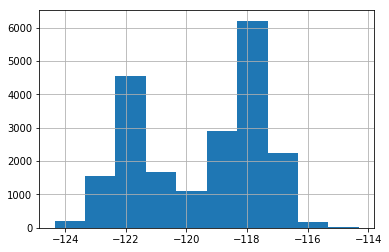

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline  
df["lat"].hist()

In [5]:
df1 = df.query("lat <= -119")

In [6]:
df2 = df.query("lat > -119")

## Label the values from the first group as 0

In [7]:
df1["DS"] = 0

/home/admin2/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Label the values from the second group as 1

In [8]:
df2["DS"] = 1

/home/admin2/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Combine the groups

In [9]:
dfc = pd.concat([df1, df2])

In [10]:
preds = dfc.columns.tolist()
preds.remove("DS")
X = dfc[preds]
Y = dfc["DS"]


## Create a test set to check the accuracy of the classifier

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [12]:
X.dtypes

lat              float64
long             float64
housingMedAge      int64
totalRooms         int64
totalBedrooms      int64
population         int64
households         int64
medianIncome     float64
dtype: object

## Develop a Classifier

In [13]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth= 3, random_state=0)

/home/admin2/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [14]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

## Check if we can accurately discriminate the datasets

In [15]:
clf.score(X_test, y_test)

1.0

## Discussion of Results
It looks like we can accurately discriminate the two datasets using a classifier. In this case, it is clear that dataset shift has occured.

In [16]:
df1.shape

(9657, 9)

In [17]:
df2.shape

(10982, 9)

## What features are important to discriminate between the two datasets?
We can plot the feature importances associated with the classifier to find out what features are most important to the classifier.

/home/admin2/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.
/home/admin2/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()


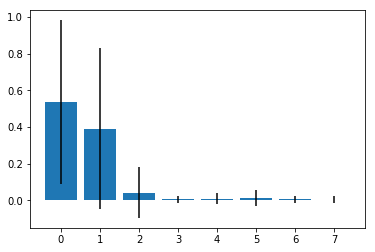

In [18]:
import numpy as np
importance = clf.feature_importances_
importance = pd.DataFrame(importance, index=X_train.columns, 
                          columns=["Importance"])

importance["Std"] = np.std([tree.feature_importances_
                            for tree in clf.estimators_], axis=0)

x = range(importance.shape[0])
y = importance.ix[:, 0]
yerr = importance.ix[:, 1]

plt.bar(x, y, yerr=yerr, align="center")

plt.show()

In [19]:
X_train.columns

Index(['lat', 'long', 'housingMedAge', 'totalRooms', 'totalBedrooms',
       'population', 'households', 'medianIncome'],
      dtype='object')

## Discussion
As expected, the **lat** variable is the most important feature to discriminate the two datasets.

## Alternative Experiment
Let's randomly create two datasets from the **california housing** dataset and see if we can develop a classifier to discriminate between them. We randomly split the dataset into two parts.

In [20]:
np.random.seed(42)
msk = np.random.rand(len(df)) < 0.5
df1 = df[msk]
df2 = df[~msk]

## Label the two datasets

In [21]:
df1["DS"] = 0
df2["DS"] = 1
dfc = pd.concat([df1, df2])
preds = dfc.columns.tolist()
preds.remove("DS")
X = dfc[preds]
Y = dfc["DS"]

/home/admin2/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/admin2/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Train and classifier and check if we can discriminate between the datasets

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.5052121568051681

## Results
The accuracy of the developed classifier is about **0.5** - about as accurate as tossing a coin. In other words, we cannot discriminate between the two datasets. If we received these as consecutive batches of data, we can conclude that **covariate shift has not occured.**

**Arangopipe** will support covariate shift detection. To do: illustrate the above with an API call to **Arangopipe**